# COGS 108 Final Project

## Group Members

- A13628601 Zeyun Wu
- A14818302 Zhaoyue Xiang
- A14419227 Qian Zhang
- A14534893 Ziteng Wang
- A13370971 Sizhe Qiu
- A92008073 Sizhao Li

## Research Question
### Is the revenue of popular movies in recent ten years propotional to rating on IMDB and MovieLens? How would other related factors affect the prediction of the revenue?

### Hypothesis



The revenue of recent popular movies is propotional to rating on IMDB and MovieLens. The factors such as genres and directors also affect correlation between revenue and rating, thus a multiple regression would make a good prediction for revenue.

### Introduction and Background


Watching movie is a major entertainment for modern people. Movies provide people with amusement and excitement widely. As the movie industry developing swiftly, researchers and scholars are interested in movie’s effects on different facets, such as Baron’s research in 2006 on Dinner and a movie, which studies films’ “narrative design in ways that shape viewers' perception of the characters and their interactions, the social dynamics explored in a film, and the ideological perspectives conveyed by a film.” In fall 2017, a group of COGS 108 students also put their effort on studying the relationship between movies and crimes. Inspired by their researches, our group wonder what elements may influence the box office of movies.

To general understanding, movies receive good reviews also have high revenues. That is, the revenue of the movie is proportional to the rating of the movie. Holding this hypothesis, we go through the dataset of IMDB, which includes 1,000 most popular movies between 2006 and 2016, and the MovieLens dataset with ratings of 45000 movies. The data fields included are: Title, Genre, Description, Director, Actors, Year, Runtime, Rating, Votes, Revenue, and meta score. By processing these datasets, we continue to prove whether our hypothesis is wrong or right or partially right, which means that there are other factors involved in the relationship between the revenue and rating of the movie.  As we further analyze the dataset, we may find other factors that influence the rating and box office of movies.

Here we are going to explain certain terms we use during the project. The factor Votes represents how many users scored the movies, and meta score is the rating of the movies by leading critics.


References (include links):
* 1)Baron, C. (2006). Dinner and a Movie [Abstract]. Food, Culture & Society, 9(1), 93-117. doi:10.2752 link: http://www.tandfonline.com/doi/abs/10.2752/155280106778055190
* 2)Baker-harvey, H., Lin, T., & Meka, P. (2017, July 14). FinalProjects/COGS108-Sp17-PG034. link: https://github.com/COGS108/FinalProjects/blob/master/COGS108-Sp17-PG034.ipynb



### Ethics and Privacy

The first dataset is from an open-access website Kaggle. It is collected from a public movie review website IMDB. For the second dataset of MovieLens, the author (grouplens) of it permits the use of the dataset for research purpose. Moreover, the datasets we use contain only the user ID (which we will also remove when doing data cleaning) and no other personal information. For the research purpose, we only evaluate the relationship of revenue and rating, taking voting, genre and meta score into consideration. We will not use directors or actors as our research objects, which will not involve personal issues.

However, if we only use the dataset from one website, it is possible that the results only reflect the views of certain group of users, which could be biased in terms of representing general public ideas of the movies. To resolve the potential bias, we decide to pull data from two major movie review websites, IMDB and MovieLens, to make our data representing more general and diverse views. In this way, our research is more reflective of the reality, which will make more reliable predictions.

### Dataset(s)


- Dataset Name: IMDB data from 2006 to 2016
- Link to the dataset: https://www.kaggle.com/PromptCloudHQ/imdb-data/data
- Number of observations: 1000

Describtion of dataset: It is a dataset of 1000 most popular movies on IMDB, with title, genre, description, director, actors, year, runtime, rating, votes, revenue, and metascore. 


- Dataset Name: MovieLens Latest Dataset
- Link to the dataset: https://grouplens.org/datasets/movielens/latest/
- Number of observations: 26,000,000

Describtion of dataset: 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags. Last updated 8/2017.

### Imports

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from pandas.plotting import scatter_matrix

C:\Users\by634\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Integration

Since the MovieLens dataset contains users' ratings to different movies, it needs to be processed the date for the use with the observations from the other dataset.<br>
Please Note: as the dataset is large, certain cells might take a long time (couple minutes) to run; but we have already ran it and wrote the results into the file named "integrated_data.csv" for later use.

In [ ]:
# read data sets
df_imdb = pd.read_csv('IMDB-Movie-Data.csv')
df_ML_id = pd.read_csv('movies.csv')
df_ML_rating = pd.read_csv('ratings.csv')

In [ ]:
df_imdb

In [ ]:
df_ML_id

In [ ]:
df_ML_rating

In [ ]:
# return the index of s in l if there is a match
def checkExist(s, l):
    for i in range (0, len(l)):
        if (s in l[i]):
            return i
    return False

In [ ]:
# get title of movies, dropping the old ones (not contained in the imdb data frame)
imdb_title = df_imdb['Title']
df_ML_id[~df_ML_id['title'].str.contains('\(19')]
df_ML_id = df_ML_id.dropna(axis=0, how='any')

In [ ]:
# insert a new column
col_name = df_imdb.columns.tolist()
col_name.insert(1,'ML_id')  
df_imdb = df_imdb.reindex(columns=col_name)
# get the columns
df_ML_id = df_ML_id.reset_index(drop=True)
imdb_titles = df_imdb['Title']

In [ ]:
# add the ML id into the imdb dataframe
for index in range (0, len(imdb_titles)):
    id_index = checkExist(imdb_titles[index], df_ML_id['title'])
    if (id_index != False):
        mvid = df_ML_id.loc[id_index:id_index, 'movieId']
        df_imdb.set_value(index, 'ML_id', mvid)

In [ ]:
# drop nan and insert a column for the ML_score
df_imdb = df_imdb.dropna(axis=0, how='any')
col_name = df_imdb.columns.tolist()
col_name.insert(1,'ML_score')  
df_imdb = df_imdb.reindex(columns=col_name)
# add votes column
col_name = df_imdb.columns.tolist()
col_name.insert(1,'ML_votes')  
df_imdb = df_imdb.reindex(columns=col_name)

In [ ]:
# calculate score
def calculateScore(movie_id, index):
    id_rating= df_ML_rating[df_ML_rating['movieId'] == movie_id]
    id_rating = id_rating.reset_index(drop=True)

    df_imdb.set_value(index,'ML_votes',  len(id_rating))
    
    score_sum = id_rating.sum()['rating']
    score = score_sum/len(id_rating['rating'])
    df_imdb.set_value(index, 'ML_score', score*2)

In [ ]:
df_imdb = df_imdb.reset_index(drop=True)
ML_id = df_imdb['ML_id']
for index in range (0, len(ML_id)):
        calculateScore(ML_id[index], index)

In [ ]:
# calculate the overall score
df_imdb['Overall'] = (df_imdb.ML_score * df_imdb.ML_votes + df_imdb.Rating * df_imdb.Votes) / (df_imdb.Votes+df_imdb.ML_votes)

In [ ]:
# write the results to file
df_imdb.to_csv("integrated_data.csv")

### Data Cleaning

Since each movie's data is relatively independent to other movies, calculating standard deviation or variance is unneccesary due to the fact that we do not need to attain the stability of our dataset. However, some attributes such as director and actors are irrelevant to our topic, so we still need to do data cleaning to exclude miscellaneous data from our dataset. Furthermore, in order to analyze the relationship between genre and revenue, we need to filter different types of movies as all movies have various sorts of genres.

In [54]:
#import the dataset to a dataframe
df = pd.read_csv("integrated_data.csv")

In [55]:
#drop all irrelevant attributes from the dataframe to secure the privacy and ethics.
df = df.drop(["Rank","Description","Director", "Actors", "Description", "Runtime (Minutes)","Unnamed: 0","ML_id"], axis = 1)

In [56]:
#drop rows which have Nan.
df = df.dropna()

In [57]:
# filters to check whether a movie has a genre or not
def Action_filter(name):
    if "Action" in name:
        result = 1
    else:
        result = 0
        
    return result

def Adventure_filter(name):
    if "Adventure" in name:
        result = 1
    else:
        result = 0
        
    return result

def Comedy_filter(name):
    if "Comedy" in name:
        result = 1
    else:
        result = 0
        
    return result

def Drama_filter(name):
    if "Drama" in name:
        result = 1
    else:
        result = 0
        
    return result

def Biography_filter(name):
    if "Biography" in name:
        result = 1
    else:
        result = 0
        
    return result

def Fantasy_filter(name):
    if "Fantasy" in name:
        result = 1
    else:
        result = 0
        
    return result

def Horror_filter(name):
    if "Horror" in name:
        result = 1
    else:
        result = 0
        
    return result

def Mystery_filter(name):
    if "Mystery" in name:
        result = 1
    else:
        result = 0
        
    return result

def Romance_filter(name):
    if "Romance" in name:
        result = 1
    else:
        result = 0
        
    return result

def Scifi_filter(name):
    if "Sci-Fi" in name:
        result = 1
    else:
        result = 0
        
    return result

def Crime_filter(name):
    if "Crime" in name:
        result = 1
    else:
        result = 0
        
    return result

def Thriller_filter(name):
    if "Thriller" in name:
        result = 1
    else:
        result = 0
        
    return result


In [58]:
#build 12 columns to collect the result of those filters.
df['Action'] = df['Genre'].apply(Action_filter) 
df['Adventure'] = df['Genre'].apply(Adventure_filter) 
df['Biography'] = df['Genre'].apply(Biography_filter) 
df['Comedy'] = df['Genre'].apply(Comedy_filter) 
df['Crime'] = df['Genre'].apply(Crime_filter) 
df['Drama'] = df['Genre'].apply(Drama_filter) 
df['Fantasy'] = df['Genre'].apply(Fantasy_filter) 
df['Horror'] = df['Genre'].apply(Horror_filter) 
df['Mystery'] = df['Genre'].apply(Mystery_filter) 
df['Romance'] = df['Genre'].apply(Romance_filter) 
df['Sci-Fi'] = df['Genre'].apply(Scifi_filter) 
df['Thriller'] = df['Genre'].apply(Thriller_filter) 

In [59]:
#split the Genre for convenient purpose
df1 = df['Genre'].str.split(',', expand = True)

In [60]:
#save the result to the main dataframe
df['Genre1'] = df1[0]
df['Genre2'] = df1[1]
df['Genre3'] = df1[2]

In [61]:
#reset the index and drop the original Genre
df = df.reset_index(drop = True)
df = df.drop(['Genre'], axis = 1)

In [62]:
#use dictionary to find out the most popular genre of movie
dict_1 ={} 
for index, row in df.iterrows():
    if dict_1.__contains__(row['Genre1']):
        result = dict_1[row['Genre1']]
        dict_1[row['Genre1']] = result + 1
    else:
        dict_1[row['Genre1']] = 1

for index, row in df.iterrows():
    if dict_1.__contains__(row['Genre2']):
        result = dict_1[row['Genre2']]
        dict_1[row['Genre2']] = result + 1
    else:
        dict_1[row['Genre2']] = 1
        
for index, row in df.iterrows():
    if dict_1.__contains__(row['Genre3']):
        result = dict_1[row['Genre3']]
        dict_1[row['Genre3']] = result + 1
    else:
        dict_1[row['Genre3']] = 1

In [63]:
#print out the result
dict_1

{'Action': 245,
 'Adventure': 219,
 'Horror': 71,
 'Animation': 41,
 'Comedy': 218,
 'Biography': 57,
 'Drama': 351,
 'Crime': 111,
 'Mystery': 70,
 'Sci-Fi': 95,
 'Fantasy': 75,
 'Thriller': 125,
 'Family': 46,
 None: 266,
 'Romance': 101,
 'History': 23,
 'Music': 14,
 'Western': 4,
 'War': 9,
 'Musical': 5,
 'Sport': 14}

In [64]:
#delete the none type
del dict_1[None]

In [65]:
# delete Genres which do not have over 50 movies as they are not representative 
for key, value in list(dict_1.items()):
    if value < 50:
        del dict_1[key]

In [66]:
# sort the Genre from the greatest to the least
dict_1 = sorted(dict_1.items(), key = lambda item:item[1] , reverse = True )
dict_1

[('Drama', 351),
 ('Action', 245),
 ('Adventure', 219),
 ('Comedy', 218),
 ('Thriller', 125),
 ('Crime', 111),
 ('Romance', 101),
 ('Sci-Fi', 95),
 ('Fantasy', 75),
 ('Horror', 71),
 ('Mystery', 70),
 ('Biography', 57)]

In [67]:
#build 12 dataframe for each genre
df_Action = df[(df['Genre1']=='Action') | (df['Genre2']=='Action')| (df['Genre3'] == 'Action')]
df_Drama = df[(df['Genre1']=='Drama') | (df['Genre2']=='Drama')| (df['Genre3'] == 'Drama')]
df_Comedy = df[(df['Genre1']=='Comedy') | (df['Genre2']=='Comedy')| (df['Genre3'] == 'Comedy')]
df_Adventure = df[(df['Genre1']=='Adventure') | (df['Genre2']=='Adventure')| (df['Genre3'] == 'Adventure')]
df_Thriller = df[(df['Genre1']=='Thriller') | (df['Genre2']=='Thriller')| (df['Genre3'] == 'Thriller')]
df_Crime = df[(df['Genre1']=='Crime') | (df['Genre2']=='Crime')| (df['Genre3'] == 'Crime')]
df_Romance = df[(df['Genre1']=='Romance') | (df['Genre2']=='Romance')| (df['Genre3'] == 'Romance')]
df_SciFi = df[(df['Genre1']=='Sci-Fi') | (df['Genre2']=='Sci-Fi')| (df['Genre3'] == 'Sci-Fi')]
df_Fantasy = df[(df['Genre1']=='Fantasy') | (df['Genre2']=='Fantasy')| (df['Genre3'] == 'Fantasy')]
df_Horror = df[(df['Genre1']=='Horror') | (df['Genre2']=='Horror')| (df['Genre3'] == 'Horror')]
df_Mystery = df[(df['Genre1']=='Mystery') | (df['Genre2']=='Mystery')| (df['Genre3'] == 'Mystery')]
df_Biography = df[(df['Genre1']=='Biography') | (df['Genre2']=='Biography')| (df['Genre3'] == 'Biography')]

In [68]:
#print out the dataframe to check
df

,ML_votes,ML_score,Title,Year,Rating,Votes,Revenue (Millions),Metascore,Overall,Action,...,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,Genre1,Genre2,Genre3
0,12183.0,7.855536,Guardians of the Galaxy,2014,8.1,757074,333.13,76.0,8.096128,1,...,0,0,0,0,0,1,0,Action,Adventure,Sci-Fi
1,6139.0,6.748493,Prometheus,2012,7.0,485820,126.46,65.0,6.996862,0,...,0,0,0,1,0,1,0,Adventure,Mystery,Sci-Fi
2,174.0,6.000000,Split,2016,7.3,157606,138.12,62.0,7.298566,0,...,0,0,1,0,0,0,1,Horror,Thriller,None
3,12416.0,8.055171,Sing,2016,7.2,60545,270.32,59.0,7.345527,0,...,0,0,0,0,0,0,0,Animation,Comedy,Family
4,1805.0,5.765097,Suicide Squad,2016,6.2,393727,325.02,40.0,6.198015,1,...,0,1,0,0,0,0,0,Action,Adventure,Fantasy
5,225.0,6.155556,The Great Wall,2016,6.1,56036,45.13,42.0,6.100222,1,...,0,1,0,0,0,0,0,Action,Adventure,Fantasy
6,1847.0,7.642664,La La Land,2016,8.3,258682,151.06,93.0,8.295340,0,...,1,0,0,0,0,0,0,Comedy,Drama,Music
7,82.0,6.109756,The Lost City of Z,2016,7.1,7188,8.01,78.0,7.088831,1,...,0,0,0,0,0,0,0,Action,Adventure,Biography
8,221.0,5.927602,Passengers,2016,7.0,192177,100.01,41.0,6.998768,0,...,1,0,0,0,1,0,0,Adventure,Drama,Romance
9,1709.0,7.407841,Fantastic Beasts and Where to Find Them,2016,7.5,232072,234.02,66.0,7.499326,0,...,0,1,0,0,0,0,0,Adventure,Family,Fantasy


In [69]:
#rename the column for convenient purpose
df.columns = ["ML_votes","ML_score","Title",  "Year", "IMDB_Rating", "IMDB_votes",
              "Revenue", "Metascore","Average_Rating",'Action','Adventure','Biography',
             'Comedy','Crime','Drama','Fantasy','Horror','Mystery','Romance','SciFi','Thriller',"Genre1","Genre2","Genre3"]

In [70]:
#get the total votes 
df["Total_Votes"]=df["IMDB_votes"]+df["ML_votes"]
df

,ML_votes,ML_score,Title,Year,IMDB_Rating,IMDB_votes,Revenue,Metascore,Average_Rating,Action,...,Fantasy,Horror,Mystery,Romance,SciFi,Thriller,Genre1,Genre2,Genre3,Total_Votes
0,12183.0,7.855536,Guardians of the Galaxy,2014,8.1,757074,333.13,76.0,8.096128,1,...,0,0,0,0,1,0,Action,Adventure,Sci-Fi,769257.0
1,6139.0,6.748493,Prometheus,2012,7.0,485820,126.46,65.0,6.996862,0,...,0,0,1,0,1,0,Adventure,Mystery,Sci-Fi,491959.0
2,174.0,6.000000,Split,2016,7.3,157606,138.12,62.0,7.298566,0,...,0,1,0,0,0,1,Horror,Thriller,None,157780.0
3,12416.0,8.055171,Sing,2016,7.2,60545,270.32,59.0,7.345527,0,...,0,0,0,0,0,0,Animation,Comedy,Family,72961.0
4,1805.0,5.765097,Suicide Squad,2016,6.2,393727,325.02,40.0,6.198015,1,...,1,0,0,0,0,0,Action,Adventure,Fantasy,395532.0
5,225.0,6.155556,The Great Wall,2016,6.1,56036,45.13,42.0,6.100222,1,...,1,0,0,0,0,0,Action,Adventure,Fantasy,56261.0
6,1847.0,7.642664,La La Land,2016,8.3,258682,151.06,93.0,8.295340,0,...,0,0,0,0,0,0,Comedy,Drama,Music,260529.0
7,82.0,6.109756,The Lost City of Z,2016,7.1,7188,8.01,78.0,7.088831,1,...,0,0,0,0,0,0,Action,Adventure,Biography,7270.0
8,221.0,5.927602,Passengers,2016,7.0,192177,100.01,41.0,6.998768,0,...,0,0,0,1,0,0,Adventure,Drama,Romance,192398.0
9,1709.0,7.407841,Fantastic Beasts and Where to Find Them,2016,7.5,232072,234.02,66.0,7.499326,0,...,1,0,0,0,0,0,Adventure,Family,Fantasy,233781.0


### Data Analysis & Visualization

Text(0,0.5,'Revenue(Million)')

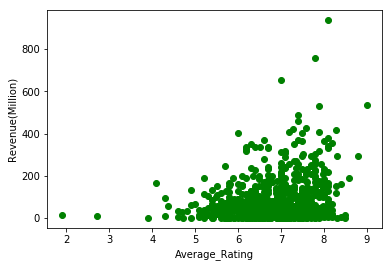

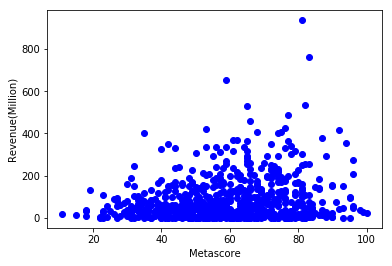

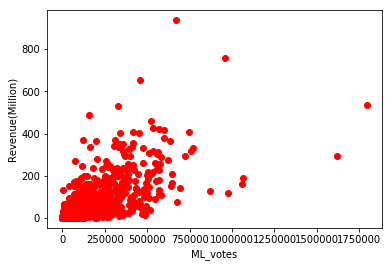

In [71]:
#visualize data
plt.figure(1)
x=df['Average_Rating']
y=df['Revenue']
plt.plot(x,y,'go')
plt.xlabel('Average_Rating')
plt.ylabel('Revenue(Million)')

plt.figure(2)
x=df['Metascore']
y=df['Revenue']
plt.plot(x,y,'bo')
plt.xlabel('Metascore')
plt.ylabel('Revenue(Million)')



plt.figure(3)
x=df['Total_Votes']
y=df['Revenue']
plt.plot(x,y,'ro')
plt.xlabel('ML_votes')
plt.ylabel('Revenue(Million)')

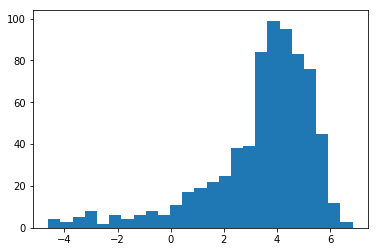

In [72]:
#log renvenue histogram
df.loc[df.Revenue == 0, ['Revenue']] =1
hist1 = plt.hist(np.log(df['Revenue'].dropna()), bins = 25)

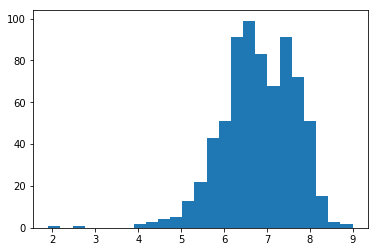

In [73]:
hist2 = plt.hist(df['Average_Rating'],bins =25)

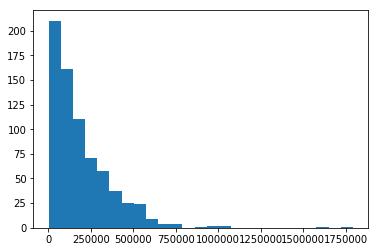

In [74]:
hist3 = plt.hist(df['Total_Votes'],bins = 25)

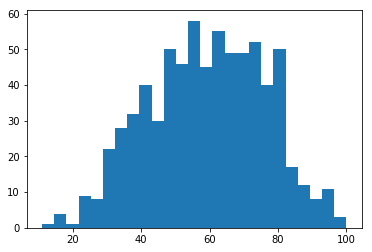

In [75]:
hist4 = plt.hist(df['Metascore'],bins = 25)

In [76]:
f= "Revenue~Average_Rating"
[outcome_1,predictors_1]=patsy.dmatrices(f,df)
mod_1=sm.OLS(outcome_1,predictors_1)
res_1=mod_1.fit()

In [77]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     43.90
Date:                Sat, 17 Mar 2018   Prob (F-statistic):           6.77e-11
Time:                        14:33:53   Log-Likelihood:                -4346.9
No. Observations:                 720   AIC:                             8698.
Df Residuals:                     718   BIC:                             8707.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -115.4315     30.521     -3.

#### Interpretation:
* According to OLS report of Revenue~Average_Rating, the p value is lower than alpha=0.01, so the relation between them is strong.

In [78]:
f= "Revenue~Average_Rating+Metascore"
[outcome_2,predictors_2]=patsy.dmatrices(f,df)
mod_2=sm.OLS(outcome_2,predictors_2)
res_2=mod_2.fit()

In [79]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     22.02
Date:                Sat, 17 Mar 2018   Prob (F-statistic):           5.24e-10
Time:                        14:33:57   Log-Likelihood:                -4346.8
No. Observations:                 720   AIC:                             8700.
Df Residuals:                     717   BIC:                             8713.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -111.1493     32.127     -3.

#### Interpretation:
* According to OLS report of Revenue~Average_Rating+Metascore, the p value for Metascore is higher than 0.01, so the relation between revenue and metascore is weak.

In [80]:
f= "Revenue~Average_Rating+Total_Votes"
[outcome_3,predictors_3]=patsy.dmatrices(f,df)
mod_3=sm.OLS(outcome_3,predictors_3)
res_3=mod_3.fit()

In [81]:
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     251.0
Date:                Sat, 17 Mar 2018   Prob (F-statistic):           2.28e-83
Time:                        14:33:59   Log-Likelihood:                -4177.2
No. Observations:                 720   AIC:                             8360.
Df Residuals:                     717   BIC:                             8374.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        112.4915     26.504      4.

#### Interpretation:
* According to this OLS report, the p values for both Average_Rating and Total_Votes are smaller than 0.01, we think that they are both related to Revenue.

In [82]:
f= "Revenue~Average_Rating+Total_Votes+Action+Adventure+Biography+Comedy+Crime+Drama+Fantasy+Horror+Mystery+Romance+SciFi+Thriller"
[outcome_4,predictors_4]=patsy.dmatrices(f,df)
mod_4=sm.OLS(outcome_4,predictors_4)
res_4=mod_4.fit()

In [83]:
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     57.06
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          6.88e-106
Time:                        14:34:01   Log-Likelihood:                -4095.6
No. Observations:                 720   AIC:                             8221.
Df Residuals:                     705   BIC:                             8290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         52.5264     29.091      1.

#### Interpretation:
* When we take genres of films into consideration, we can see that the p value of Average_Rating now gets higher than 0.01, so that we think only Total_Votes and three genres (Adventure, Drama and Mystery) have strong impact on revenue.


We reject Average_Rating, Action, Biography, Comedy, Crime, Fantasy, Horror, Romance, SciFi, Thriller

In [86]:
f= "Revenue~Total_Votes+Adventure+Drama+Mystery"
[outcome_5,predictors_5]=patsy.dmatrices(f,df)
mod_5=sm.OLS(outcome_5,predictors_5)
res_5=mod_5.fit()

In [87]:
print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          1.25e-113
Time:                        14:34:12   Log-Likelihood:                -4101.2
No. Observations:                 720   AIC:                             8212.
Df Residuals:                     715   BIC:                             8235.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      29.8332      5.578      5.348      

#### Interpretation
* According to the results of all OLS above, a function to predict revenue can be built that Revenue=29.8315+0.0003*Total_Votes+55.1964*Adventure-34.1670*Drama-28.2406*Mystery, Adventure, Drama or Mystery equals to 1 if the film belongs to this genre, equals to 0 if not.


In [88]:
df["Predicted_Revenue"]=29.8315+0.0003*df["Total_Votes"]+55.1964*df["Adventure"]-34.1670*df["Drama"]-28.2406*df["Mystery"]

df

,ML_votes,ML_score,Title,Year,IMDB_Rating,IMDB_votes,Revenue,Metascore,Average_Rating,Action,...,Horror,Mystery,Romance,SciFi,Thriller,Genre1,Genre2,Genre3,Total_Votes,Predicted_Revenue
0,12183.0,7.855536,Guardians of the Galaxy,2014,8.1,757074,333.13,76.0,8.096128,1,...,0,0,0,1,0,Action,Adventure,Sci-Fi,769257.0,315.8050
1,6139.0,6.748493,Prometheus,2012,7.0,485820,126.46,65.0,6.996862,0,...,0,1,0,1,0,Adventure,Mystery,Sci-Fi,491959.0,204.3750
2,174.0,6.000000,Split,2016,7.3,157606,138.12,62.0,7.298566,0,...,1,0,0,0,1,Horror,Thriller,None,157780.0,77.1655
3,12416.0,8.055171,Sing,2016,7.2,60545,270.32,59.0,7.345527,0,...,0,0,0,0,0,Animation,Comedy,Family,72961.0,51.7198
4,1805.0,5.765097,Suicide Squad,2016,6.2,393727,325.02,40.0,6.198015,1,...,0,0,0,0,0,Action,Adventure,Fantasy,395532.0,203.6875
5,225.0,6.155556,The Great Wall,2016,6.1,56036,45.13,42.0,6.100222,1,...,0,0,0,0,0,Action,Adventure,Fantasy,56261.0,101.9062
6,1847.0,7.642664,La La Land,2016,8.3,258682,151.06,93.0,8.295340,0,...,0,0,0,0,0,Comedy,Drama,Music,260529.0,73.8232
7,82.0,6.109756,The Lost City of Z,2016,7.1,7188,8.01,78.0,7.088831,1,...,0,0,0,0,0,Action,Adventure,Biography,7270.0,87.2089
8,221.0,5.927602,Passengers,2016,7.0,192177,100.01,41.0,6.998768,0,...,0,0,1,0,0,Adventure,Drama,Romance,192398.0,108.5803
9,1709.0,7.407841,Fantastic Beasts and Where to Find Them,2016,7.5,232072,234.02,66.0,7.499326,0,...,0,0,0,0,0,Adventure,Family,Fantasy,233781.0,155.1622


Text(0,0.5,'Revenue(Million)')

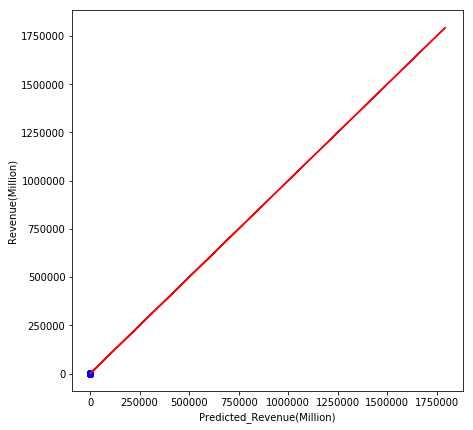

In [89]:
plt.figure(1)
plt.figure(figsize=(7,7))
m=df['Predicted_Revenue']
n=df['Revenue']

plt.plot(m,n,'bo',x,x,'r-')
plt.xlabel('Predicted_Revenue(Million)')
plt.ylabel('Revenue(Million)')

In [90]:
f= "Revenue~Predicted_Revenue"
[outcome_6,predictors_6]=patsy.dmatrices(f,df)
mod_6=sm.OLS(outcome_6,predictors_6)
res_6=mod_6.fit()

In [91]:
print(res_6.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     789.6
Date:                Sat, 17 Mar 2018   Prob (F-statistic):          8.99e-118
Time:                        14:34:17   Log-Likelihood:                -4101.2
No. Observations:                 720   AIC:                             8206.
Df Residuals:                     718   BIC:                             8216.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0106      4.05

#### Interpretation
* Then, we plotted predicted revenue versus actual revenue. From the plot and the OLS report, we can see the result that predicted value is very close to the actual value.

In [92]:
#function to produce dataframe for plotting
#for each genre, the dataframe contains a column of years and a column of average revenue in that year
def year_average_revenue(df_genre):
    dict_genre = {}
    for years in range (2006, 2017):
        for index, row in df_genre.iterrows():
            if dict_genre.__contains__(row['Year']):
                continue
            else:
                dict_genre[years] = sum(df_genre[df['Year'] == years]['Revenue (Millions)'])/df_genre[df['Year']==years].shape[0]
    df_output = pd.DataFrame(list(dict_genre.items()), columns = ['year', 'aver_revenue'])
    return df_output

In [93]:
#call year_average_revenue to produce plotting dataframes for each genre
action = year_average_revenue(df_Action)
drama = year_average_revenue(df_Drama)
adventure = year_average_revenue(df_Adventure)
comedy = year_average_revenue(df_Comedy)
thriller = year_average_revenue(df_Thriller)
crime = year_average_revenue(df_Crime)
romance = year_average_revenue(df_Romance)
scifi = year_average_revenue(df_SciFi)
fantasy = year_average_revenue(df_Fantasy)
horror = year_average_revenue(df_Horror)
mystery = year_average_revenue(df_Mystery)
biography = year_average_revenue(df_Biography)

C:\Users\by634\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\by634\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The hold function was deprecated in version 2.0.
  import sys


Text(0,0.5,'Average Revenue(Million)')

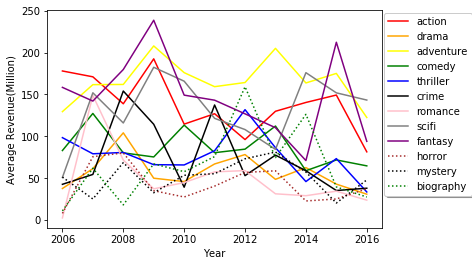

In [94]:
#genre-revenue among years
fig = plt.figure(1)
x=action['year']
y=action['aver_revenue']
plt.plot(x,y,'r-',color = 'red', label = 'action')

fig.hold()

#continue for all other popular genres
x=drama['year']
y=drama['aver_revenue']
plt.plot(x,y,'r-', color = 'orange', label = 'drama')

x=adventure['year']
y=adventure['aver_revenue']
plt.plot(x,y,'r-', color = 'yellow', label = 'adventure')

x=comedy['year']
y=comedy['aver_revenue']
plt.plot(x,y,'r-', color = 'green', label = 'comedy')

x=thriller['year']
y=thriller['aver_revenue']
plt.plot(x,y,'r-', color = 'blue', label = 'thriller')

x=crime['year']
y=crime['aver_revenue']
plt.plot(x,y,'r-', color = 'black', label = 'crime')

x=romance['year']
y=romance['aver_revenue']
plt.plot(x,y,'r-', color = 'pink', label = 'romance')

x=scifi['year']
y=scifi['aver_revenue']
plt.plot(x,y,'r-', color = 'gray', label = 'scifi')

x=fantasy['year']
y=fantasy['aver_revenue']
plt.plot(x,y,'r-', color = 'purple', label = 'fantasy')

x=horror['year']
y=horror['aver_revenue']
plt.plot(x,y,'r-', color = 'brown',ls = 'dotted', label = 'horror')

x=mystery['year']
y=mystery['aver_revenue']
plt.plot(x,y,'r-', color = 'black',ls = 'dotted', label = 'mystery')

x=biography['year']
y=biography['aver_revenue']
plt.plot(x,y,'r-', color = 'green',ls = 'dotted', label = 'biography')

legend = fig.legend(bbox_to_anchor=(0.89, 0.88), loc=2, borderaxespad=0., shadow=True)
plt.xlabel('Year')
plt.ylabel('Average Revenue(Million)')

Text(0,0.5,'Revenue(Million)')

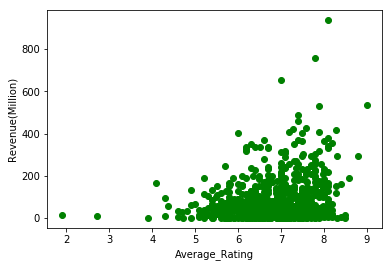

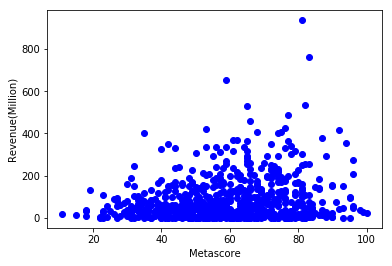

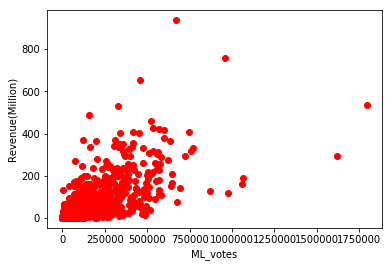

In [95]:
plt.figure(1)
x=df['Average_Rating']
y=df['Revenue']
plt.plot(x,y,'go')
plt.xlabel('Average_Rating')
plt.ylabel('Revenue(Million)')

plt.figure(2)
x=df['Metascore']
y=df['Revenue']
plt.plot(x,y,'bo')
plt.xlabel('Metascore')
plt.ylabel('Revenue(Million)')



plt.figure(3)
x=df['Total_Votes']
y=df['Revenue']
plt.plot(x,y,'ro')
plt.xlabel('ML_votes')
plt.ylabel('Revenue(Million)')



#### Interpretation
* From the three plots, we can see that only Total Votes and Revenue have a seemingly proportional relation. This explains why we include Total Votes in the function of prediction instead of other two variables.

### Conclusion & Discussion

* From the results of OLS analysis, we found that there are three genres that obviously affect the revenue: mystery, adventure and drama. From the plot of average revenue of each genre during 2006 to 2016, we can see that the revenue of adventure films is always quite large, while those of Mystery and Drama are quite low. This may also implied that the result from our analysis is to some extent correct: that in the function of prediction, the coefficient of Adventure is positive, the coefficient of Mystery or Drama is negative.

* From the diagrams above, we can conclude that votes is strongly correlated with the revenue. Also, we noted that at first the rating of the movie seems to be correlated with the revenue, but after further evaluation, we found that it is the genre of the movies that affects the revenue. We suggest that the number of votes reflects the popularity of a movie, and therefore the revenue is correlated with the popularity.

#### Limitations:
* Our data source is not balanced: the sample pool from the MovieLens database is significantly larger than IMDB, causing waste of the observations from the MovieLens database.
* As the number of votes in the two datasets is not balanced either, the result of correlating votes to the revenue might be affected.

#### Future Directions:
* To reduce the effect of the limitation, further studies can include more balanced datasets and the datasets with more records. 
* Our results show that the revenue can be predicted by some specific genres of movies. Therefore, it provides suggestions for the producers on what kind of movies to be made and a general sense of how much profit the movie can make.